In [20]:
%pip install torch torchtext datasets matplotlib scikit-learn

  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.1 MB/s eta 0:00:002.3 MB/s eta 0:00:01
Using cached joblib-1.5.3-py3-none-any.whl (309 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import re
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

/Users/shadiabdelsalam/Documents/education/misis/practice-year2/nlp2025/lesson2/homeworks/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
MAX_LEN = 64
BATCH_SIZE = 256
EMBED_DIM = 300
NUM_CLASSES = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [68]:
dataset = load_dataset("ag_news")

def tokenize(text):
    text = text.lower()
    return re.findall(r"[a-z]+", text)

counter = Counter()

for item in dataset["train"]:
    counter.update(tokenize(item["text"]))

MAX_VOCAB = 50_000

vocab = {"<pad>": 0, "<unk>": 1}

for word, _ in counter.most_common(MAX_VOCAB - 2):
    if word not in vocab:
        vocab[word] = len(vocab)

PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

Бинарник `gensim` не устанавливается на arm-архитектуре, поэтому работаю с txt-файлом эмбедингов

In [69]:
def load_glove(path, vocab, embed_dim=100):
    embeddings = torch.randn(len(vocab), embed_dim) * 0.01
    embeddings[PAD_IDX] = 0
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.rstrip().split(" ")
            word = values[0]
            if word in vocab:
                vec = torch.tensor(list(map(float, values[1:])), dtype=torch.float)
                embeddings[vocab[word]] = vec
    return embeddings

embedding_matrix = load_glove("glove.6B.300d.txt", vocab, EMBED_DIM)

In [70]:
class AGNewsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        tokens = tokenize(item["text"])
        
        ids = [vocab.get(t, UNK_IDX) for t in tokens[:MAX_LEN]]
        ids += [PAD_IDX] * (MAX_LEN - len(ids))

        return torch.tensor(ids, dtype=torch.long), item["label"]

train_loader = DataLoader(
    AGNewsDataset(dataset["train"]),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    AGNewsDataset(dataset["test"]),
    batch_size=BATCH_SIZE
)

In [71]:
class TextCNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, embeddings):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, 256, kernel_size=k)
            for k in (3, 4, 5, 6)
        ])

        self.bn1 = nn.BatchNorm1d(256 * 4)
        self.dropout1 = nn.Dropout(0.6)

        self.fc1 = nn.Linear(256 * 4, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.fc_out = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)

        feats = [F.relu(conv(x)).max(dim=2)[0] for conv in self.convs]
        x = torch.cat(feats, dim=1)

        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = F.relu(self.fc2(x))
        x = self.bn3(x)
        x = self.dropout3(x)

        return self.fc_out(x)

In [72]:
LR = 2e-3
EPOCHS = 10

In [73]:
model = TextCNNClassifier(len(vocab), EMBED_DIM, NUM_CLASSES, embedding_matrix)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [75]:
from sklearn.metrics import f1_score

In [76]:
train_losses = []
train_accs = []

def train_epoch():
    model.train()
    correct = total = running_loss = 0

    for x, y in tqdm(train_loader, desc="Training"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()

        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    return train_loss, train_acc

@torch.no_grad()
def evaluate():
    model.eval()
    correct = total = 0
    y_true = []
    y_pred = []

    for x, y in tqdm(test_loader, desc="Evaluating"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)

        preds = logits.argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    acc = correct / total
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_micro = f1_score(y_true, y_pred, average="micro")

    return acc, f1_macro, f1_micro

In [77]:
train_losses = []
train_accs = []
test_accs = []
test_f1s = []

FREEZE_EPOCHS = 2

for epoch in range(EPOCHS):
    if epoch == FREEZE_EPOCHS:
        model.embedding.weight.requires_grad = True

    train_loss, train_acc = train_epoch()

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_acc, test_f1_macro, test_f1_micro = evaluate()

    test_accs.append(test_acc)
    test_f1s.append(test_f1_macro)
    
    print(f"Epoch {epoch+1}: train_acc={train_acc:.4f}, "
          f"test_acc={test_acc:.4f}, "
          f"F1_macro={test_f1_macro:.4f}, "
          f"F1_micro={test_f1_micro:.4f}")

Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 1: train_acc=0.8310, test_acc=0.9049, F1_macro=0.9048, F1_micro=0.9049


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 2: train_acc=0.9090, test_acc=0.9145, F1_macro=0.9144, F1_micro=0.9145


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 3: train_acc=0.9235, test_acc=0.9243, F1_macro=0.9242, F1_micro=0.9243


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 4: train_acc=0.9466, test_acc=0.9263, F1_macro=0.9262, F1_micro=0.9263


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 5: train_acc=0.9622, test_acc=0.9276, F1_macro=0.9276, F1_micro=0.9276


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 6: train_acc=0.9746, test_acc=0.9300, F1_macro=0.9299, F1_micro=0.9300


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 7: train_acc=0.9841, test_acc=0.9299, F1_macro=0.9298, F1_micro=0.9299


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 8: train_acc=0.9895, test_acc=0.9295, F1_macro=0.9294, F1_micro=0.9295


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


Epoch 9: train_acc=0.9933, test_acc=0.9308, F1_macro=0.9307, F1_micro=0.9308


Evaluating: 100%|██████████| 30/30 [00:32<00:00,  1.09s/it]

Epoch 10: train_acc=0.9947, test_acc=0.9296, F1_macro=0.9296, F1_micro=0.9296


# Визуализация обучения

In [19]:
import matplotlib.pyplot as plt

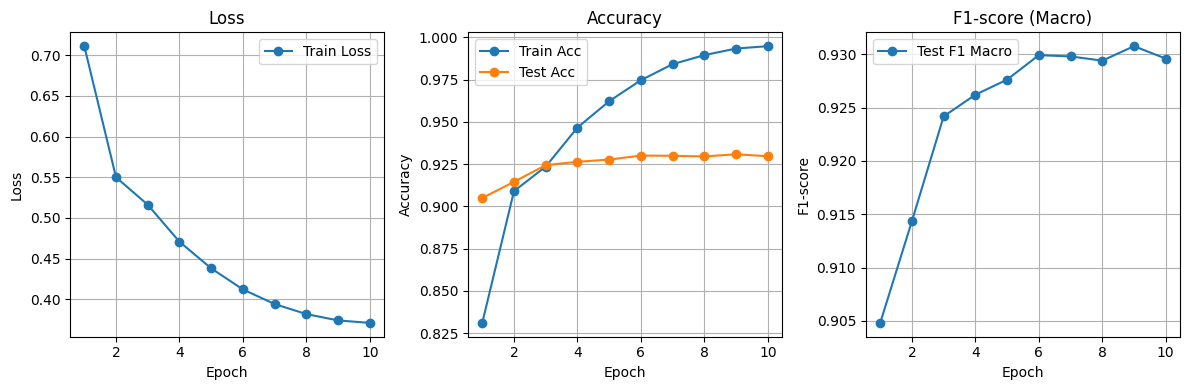

In [78]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, test_accs, marker='o', label='Test Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, test_f1s, marker='o', label='Test F1 Macro')
plt.title("F1-score (Macro)")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Построение Confusion Matrix

In [79]:
def confusion_matrix_torch(y_true, y_pred, num_classes):
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

In [80]:
@torch.no_grad()
def evaluate_confusion_matrix():
    model.eval()
    y_true = []
    y_pred = []

    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(1)
        y_true.append(y)
        y_pred.append(preds)

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    cm = confusion_matrix_torch(y_true, y_pred, num_classes=NUM_CLASSES)
    return cm

In [34]:
import numpy as np

In [81]:
def plot_confusion_matrix(cm, class_names):
    cm = cm.cpu().numpy()
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, cmap='Blues')

    # Подписи осей
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Подписи внутри ячеек
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="red")

    plt.title("Confusion Matrix")
    plt.colorbar(im)
    plt.show()

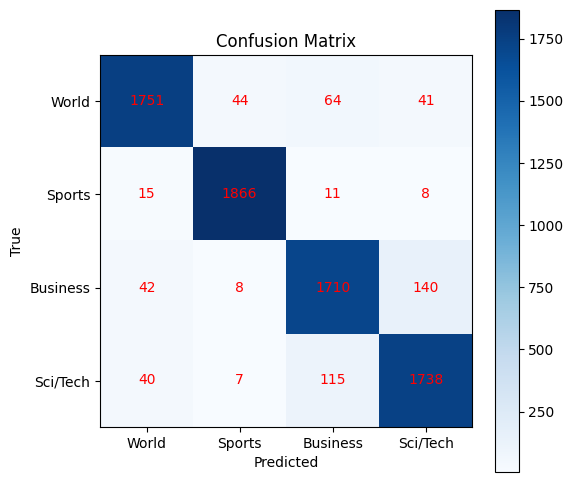

In [82]:
class_names = ["World", "Sports", "Business", "Sci/Tech"]

cm = evaluate_confusion_matrix()
plot_confusion_matrix(cm, class_names)

In [ ]:
MAX_LEN = 64
BATCH_SIZE = 64
EMBED_DIM = 300
NUM_CLASSES = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [84]:
class TextCNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, embeddings):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(embeddings)
        self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, 256, k)
            for k in (3, 4, 5, 7)
        ])

        self.bn1 = nn.BatchNorm1d(256 * 4)
        self.dropout_conv = nn.Dropout(0.3)

        self.fc = nn.Sequential(
            nn.Linear(256 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)

        feats = [
            xk.topk(2, dim=2)[0].mean(dim=2)
            for xk in [F.relu(conv(x)) for conv in self.convs]
        ]

        x = torch.cat(feats, dim=1)
        x = self.bn1(x)
        x = self.dropout_conv(x)

        return self.fc(x)

In [ ]:
EPOCHS = 10

In [88]:
model = TextCNNClassifier(len(vocab), EMBED_DIM, NUM_CLASSES, embedding_matrix)
model.to(DEVICE)

optimizer = AdamW(
    [
        {"params": model.embedding.parameters(), "lr": 5e-4},
        {"params": model.convs.parameters()},
        {"params": model.fc.parameters()},
    ],
    lr=2e-3,
    weight_decay=1e-4
)
scheduler = OneCycleLR(
    optimizer,
    max_lr=[5e-4, 2e-3, 2e-3],
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.1,
    div_factor=25,
    final_div_factor=100
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [89]:
train_losses = []
train_accs = []

def train_epoch():
    model.train()
    correct = total = running_loss = 0

    for x, y in tqdm(train_loader, desc="Training"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()

        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * y.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    return train_loss, train_acc

@torch.no_grad()
def evaluate():
    model.eval()
    correct = total = 0
    y_true = []
    y_pred = []

    for x, y in tqdm(test_loader, desc="Evaluating"):
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)

        preds = logits.argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    acc = correct / total
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_micro = f1_score(y_true, y_pred, average="micro")

    return acc, f1_macro, f1_micro

In [90]:
train_losses = []
train_accs = []
test_accs = []
test_f1s = []

FREEZE_EPOCHS = 2

for epoch in range(EPOCHS):
    if epoch == FREEZE_EPOCHS:
        model.embedding.weight.requires_grad = True

    train_loss, train_acc = train_epoch()

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_acc, test_f1_macro, test_f1_micro = evaluate()

    test_accs.append(test_acc)
    test_f1s.append(test_f1_macro)
    
    print(f"Epoch {epoch+1}: train_acc={train_acc:.4f}, "
          f"test_acc={test_acc:.4f}, "
          f"F1_macro={test_f1_macro:.4f}, "
          f"F1_micro={test_f1_micro:.4f}")

Evaluating: 100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


Epoch 1: train_acc=0.8891, test_acc=0.9133, F1_macro=0.9128, F1_micro=0.9133


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 2: train_acc=0.9255, test_acc=0.9222, F1_macro=0.9222, F1_micro=0.9222


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 3: train_acc=0.9435, test_acc=0.9261, F1_macro=0.9260, F1_micro=0.9261


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 4: train_acc=0.9642, test_acc=0.9297, F1_macro=0.9297, F1_micro=0.9297


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 5: train_acc=0.9792, test_acc=0.9246, F1_macro=0.9245, F1_micro=0.9246


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 6: train_acc=0.9895, test_acc=0.9324, F1_macro=0.9323, F1_micro=0.9324


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 7: train_acc=0.9942, test_acc=0.9296, F1_macro=0.9295, F1_micro=0.9296


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


Epoch 8: train_acc=0.9970, test_acc=0.9303, F1_macro=0.9302, F1_micro=0.9303


Evaluating: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]


Epoch 9: train_acc=0.9983, test_acc=0.9308, F1_macro=0.9307, F1_micro=0.9308


Evaluating: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it]

Epoch 10: train_acc=0.9987, test_acc=0.9305, F1_macro=0.9304, F1_micro=0.9305


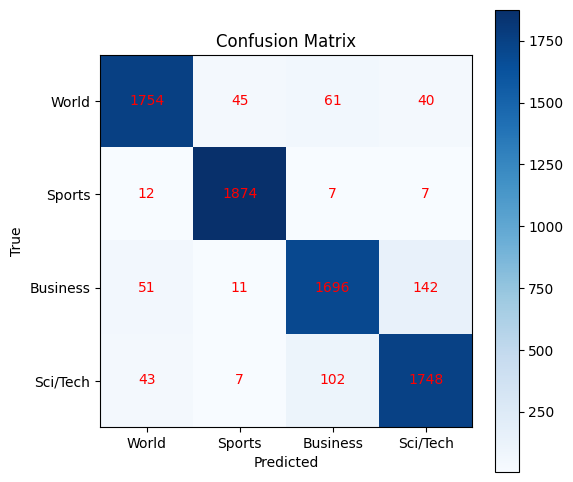

In [91]:
class_names = ["World", "Sports", "Business", "Sci/Tech"]

cm = evaluate_confusion_matrix()
plot_confusion_matrix(cm, class_names)

In [95]:
class CNNBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, embeddings):
        super().__init__()

        # Embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(embeddings)
        # Для заморозки на первых эпохах
        self.embedding.weight.requires_grad = False

        # BiLSTM
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_size=96,
            bidirectional=True,
            batch_first=True
        )

        lstm_out_dim = 96 * 2

        self.convs = nn.ModuleList([
            nn.Conv1d(lstm_out_dim, 192, kernel_size=k)
            for k in (3, 4, 5)
        ])

        self.bn_conv = nn.BatchNorm1d(192 * 3)
        self.dropout_conv = nn.Dropout(0.3)

        self.fc = nn.Sequential(
            nn.Linear(192 * 3, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)

        x, _ = self.lstm(x)
        x = x.transpose(1, 2)

        feats = [
            F.relu(conv(x)).topk(2, dim=2)[0].mean(dim=2)
            for conv in self.convs
        ]

        x = torch.cat(feats, dim=1)
        x = self.bn_conv(x)
        x = self.dropout_conv(x)

        return self.fc(x)


In [96]:
MAX_LEN = 64
BATCH_SIZE = 64
EPOCHS = 12

LR_CNN_LSTM = 2e-3
LR_EMB = 5e-4

WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1

FREEZE_EPOCHS = 2

In [ ]:
model = CNNBiLSTMClassifier(len(vocab), EMBED_DIM, NUM_CLASSES, embedding_matrix)
model.to(DEVICE)

optimizer = AdamW(
    [
        {"params": model.embedding.parameters(), "lr": LR_EMB},
        {"params": model.lstm.parameters()},
        {"params": model.convs.parameters()},
        {"params": model.fc.parameters()},
    ],
    lr=LR_CNN_LSTM,
    weight_decay=WEIGHT_DECAY
)
scheduler = OneCycleLR(
    optimizer,
    max_lr=[LR_EMB, LR_CNN_LSTM, LR_CNN_LSTM, LR_CNN_LSTM],
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.1
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [98]:
train_losses = []
train_accs = []
test_accs = []
test_f1s = []

for epoch in range(EPOCHS):
    if epoch == FREEZE_EPOCHS:
        model.embedding.weight.requires_grad = True

    train_loss, train_acc = train_epoch()

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_acc, test_f1_macro, test_f1_micro = evaluate()

    test_accs.append(test_acc)
    test_f1s.append(test_f1_macro)
    
    print(f"Epoch {epoch+1}: train_acc={train_acc:.4f}, "
          f"test_acc={test_acc:.4f}, "
          f"F1_macro={test_f1_macro:.4f}, "
          f"F1_micro={test_f1_micro:.4f}")

Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Epoch 1: train_acc=0.8827, test_acc=0.9051, F1_macro=0.9053, F1_micro=0.9051


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


Epoch 2: train_acc=0.9201, test_acc=0.9236, F1_macro=0.9236, F1_micro=0.9236


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch 3: train_acc=0.9331, test_acc=0.9293, F1_macro=0.9294, F1_micro=0.9293


Evaluating: 100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Epoch 4: train_acc=0.9482, test_acc=0.9304, F1_macro=0.9302, F1_micro=0.9304


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Epoch 5: train_acc=0.9622, test_acc=0.9313, F1_macro=0.9312, F1_micro=0.9313


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.20it/s]


Epoch 6: train_acc=0.9738, test_acc=0.9257, F1_macro=0.9256, F1_micro=0.9257


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch 7: train_acc=0.9820, test_acc=0.9300, F1_macro=0.9300, F1_micro=0.9300


Evaluating: 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


Epoch 8: train_acc=0.9882, test_acc=0.9284, F1_macro=0.9284, F1_micro=0.9284


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]


Epoch 9: train_acc=0.9923, test_acc=0.9267, F1_macro=0.9267, F1_micro=0.9267


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Epoch 10: train_acc=0.9946, test_acc=0.9263, F1_macro=0.9263, F1_micro=0.9263


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


Epoch 11: train_acc=0.9961, test_acc=0.9258, F1_macro=0.9258, F1_micro=0.9258


Evaluating: 100%|██████████| 30/30 [00:13<00:00,  2.15it/s]

Epoch 12: train_acc=0.9967, test_acc=0.9262, F1_macro=0.9261, F1_micro=0.9262


# Решение №2

In [3]:
%pip install "transformers==4.57.3" seaborn huggingface_hub

  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.5
    Uninstalling transformers-4.57.5:
      Successfully uninstalled transformers-4.57.5

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.optim import AdamW
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [8]:
dataset = load_dataset("ag_news")
train_data = dataset['train']
test_data = dataset['test']

In [18]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=64)

train_data = train_data.map(tokenize, batched=True)
test_data = test_data.map(tokenize, batched=True)

columns = ['input_ids', 'attention_mask', 'label']
train_data.set_format(type='torch', columns=columns)
test_data.set_format(type='torch', columns=columns)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

Map: 100%|██████████| 7600/7600 [00:00<00:00, 28205.81 examples/s]


In [ ]:
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes=4, dropout_rate=0.3):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        hidden_size = self.transformer.config.hidden_size
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.bn(cls_output)
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransformerClassifier(model_name).to(device)

In [22]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)

In [23]:
train_losses, train_f1s, val_f1s = [], [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        current_f1 = f1_score(all_labels, all_preds, average='macro')
        loop.set_postfix(loss=epoch_loss/ (len(all_preds)/train_loader.batch_size), f1=current_f1)


model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_f1 = f1_score(all_labels, all_preds, average='macro')
test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")


Epoch 1:  29%|████████▎                    | 541/1875 [14:53<36:43,  1.65s/it, f1=0.897, loss=0.296]


KeyboardInterrupt: 